# **Subset the LULCC data to shapefile**

By Bridget Bittmann

Date created: March 14, 2022

In [54]:
## IMPORT PACKAGES ##

import numpy as np #basic computation
!pip install geopandas
import geopandas as gpd #geopandas for .shp
import matplotlib.pyplot as plt #to create plots
import pandas as pd #to create dataframes and export .csv
!pip install rasterio
import rasterio as rso #import GeoTiff files
from rasterio.mask import mask #to crop data to a boundary
from rasterio.plot import show #to plot the image
from shapely.ops import cascaded_union #creates boundary of shapefile
import json #imports metadata
!pip install rioxarray #to clip rasters to a .shp file
import rioxarray as rxr
from rasterio.warp import calculate_default_transform, reproject, Resampling


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
## NAVIGATE TO YOUR DIRECTORY ##
%cd gdrive/MyDrive/spatial_colab/datasets/
%ls

/content/gdrive/MyDrive/spatial_colab/datasets
CDL_subsets/           irrigation_companies/  IrrMapper/
diversion_timeseries/  irrig_lbrb/            LBRB_shp/


In [34]:
class CdlDataStruct:
    """Attributes of input CDL data, location, file name, and all georeferencing information 
    :param cdl_path:    Full path to the CDl data
    :type cdl_path:     String
    :param cdl_infile:  Filename of CDL data
    :type cdl_infile:   String
    
    """

    # Constructor requires the path and file name of the input CDL data
    def __init__(self, cdl_path, cdl_infile):
        self.cdl_path = cdl_path
        self.cdl_infile = cdl_infile

    def set_cdl_proj(self, geo_transform, projection, pixel_size):
        """ Add CDL geographic transformation and projection information
        :param geo_transform:   Transformation information
        :type geo_transform:    String
        :param projection:      Projection of data
        :type projection:       String  
        :param pixel_size:      Size of pixels in meters
        :type pixel_size:       Int
        """
        self.cdl_geotransform = geo_transform
        self.cdl_projection = projection
        self.cdl_pixelsize = pixel_size

    def set_cdl_grid(self, cdl_grid):  
        """Add the 2D data to the class structure
        :param cdl_grid:    Land cover data
        :type cdl_grid:     Numpy Array
        """
        self.cdl_grid = cdl_grid

    def set_cdl_stats(self, cdl_stats):  
        """ Add the stats calculated to the class
        :param cdl_stats:   Number of cells that have each crop type
        :type cdl_stats:    Numpy Array
        """
        self.cdl_stats = cdl_stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  # Remove the CWD from sys.path while we load stuff.


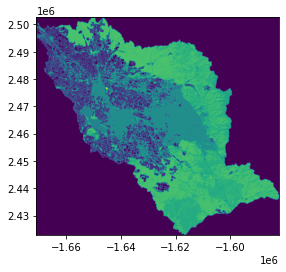

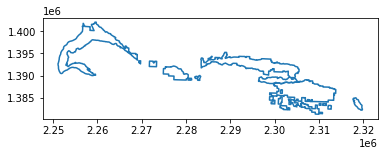

In [60]:
## CREATE A FUNCTION TO SUBSET GEOSPATIAL DATA ##
## ------------------------------------------- ##

div_name = ['Middleton Irrigation Association and Middleton Mill Ditch', 'Phyllis Canal',
            'Riverside Canal', 'Settlers Irrigation District Ditch'] #list of div names on shapfile
shp_file = gpd.read_file('subset_test_shp/subset.shp') #open shapefile
data = rso.open('CDL_subsets/2009.tif') #open cdl image
# shp_reproject = shp_file.to_crs(data.crs) #reproject the shp file to same projection
extent = shp_file['geometry'] #get the geometry from shapefile
boundary = gpd.GeoSeries(cascaded_union(extent)) #gets the boundary of the whole extent
coords = [json.loads(boundary.to_json())['features'][0]['geometry']] #gets coordinates for rasterio input

show(data)
shp_file.boundary.plot()

In [57]:
## REPROJECT THE CDL FILES TO NAD83 ##

proj_name = 'EPSG:8826'
input_imagery_file = 'CDL_subsets/2009.tif'
transformed_imagery_file = 'CDL_subsets/2009_trans.tif'
with rso.open(input_imagery_file) as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, proj_name, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': proj_name, 'transform': transform, 'width': width, 'height': height})
    with rso.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rso.band(imagery, i),
                destination=rso.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=proj_name,
                resampling=Resampling.nearest)

In [62]:
data = rso.open('CDL_subsets/2009_trans.tif')
coords = [json.loads(boundary.to_json())['features'][0]['geometry']] #gets coordinates for rasterio input
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
out_meta = data.meta.copy()

ValueError: ignored